### Task VII: Equivariant quantum neural networks

In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry.

This example is explained in the paper https://arxiv.org/abs/2205.06217 and additional background can be found in https://arxiv.org/abs/2210.08566. 

- Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.
- Train a QNN to solve the classification problem
- Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.



The study referenced [1] has presented a comprehensive solution to this task, complete with thorough benchmarks. The associated GitHub repository (https://github.com/ZhongtianD/EQNN) contains implementations of the introduced quantum circuit in Pennylane interfacing to Autograd. 

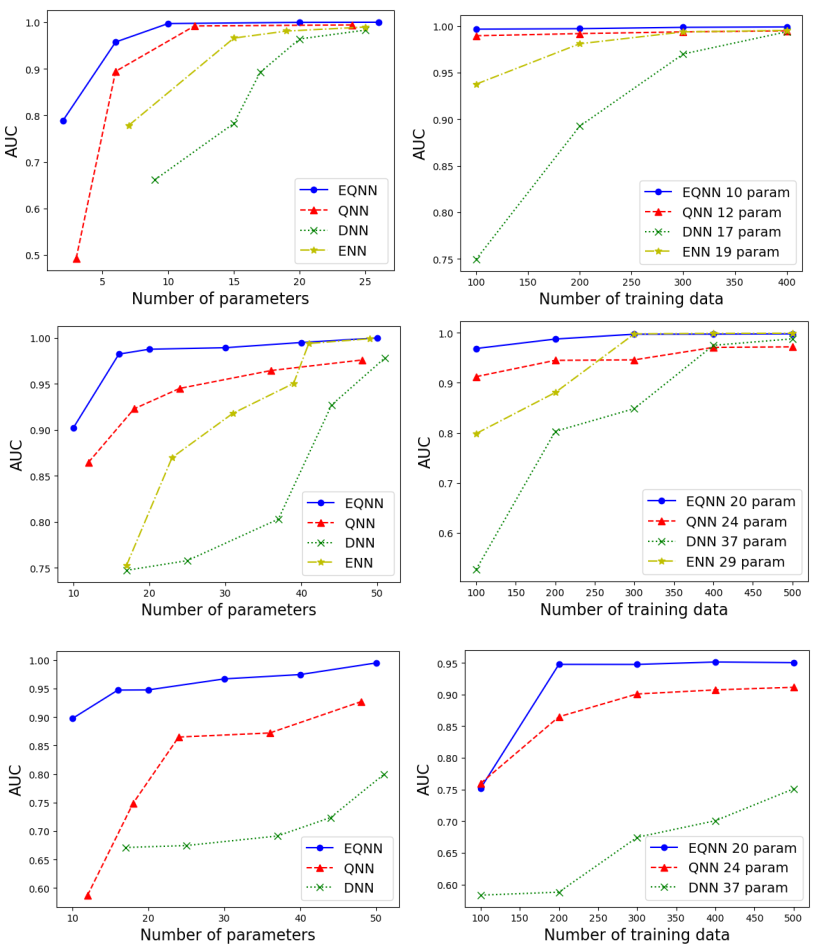

In this notebook, we aim to explore a different QNN architecture from one mentioned in the reference. We'll also reinterpret some of the mathematical expressions to align with our understanding and adapt the program to utilize PennyLane's PyTorch interface.

In [40]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

#### I. Generate Data

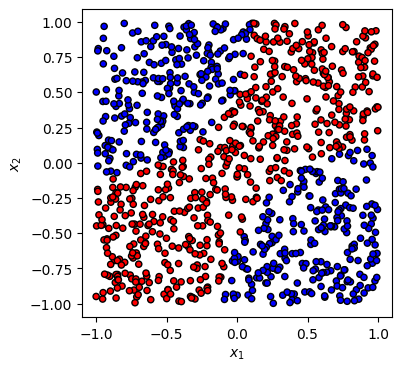

In [41]:
def generate_data(samples, center=[[-1.0, 1.0],[1.0, -1.0]], radius=1.1):
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1 # 2D: -1 to 1
        y = np.linalg.norm(x - center[0]) < radius or np.linalg.norm(x - center[1]) < radius
        
        Xvals.append(x)
        yvals.append(float(y))
    return np.array(Xvals), np.array(yvals)

def plot_data(X, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.scatter(X[:, 0], X[:, 1],  c=y, cmap=matplotlib.colors.ListedColormap(['red','blue']), s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
               
X_, y_ = generate_data(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_, y_, fig=fig, ax=ax)
plt.show()

In [42]:
def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

def density_matrix(state):
    # return torch.mm(state, torch.conj(state).t())
    return torch.matmul(state, torch.conj(state).t())

def bce_loss(params, X, y, state_labels, q_circuit):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]

    for i in range(X.size(0)):  # Assuming x is a PyTorch tensor with shape [batch_size, features]
        y_pred = q_circuit(params, X[i], dm_labels[0])
        loss += - y[i] * torch.log(y_pred) - (1 - y[i]) * torch.log(1 - y_pred)

    return loss / X.size(0)

def fidel_loss(params, X, y, state_labels, q_circuit):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    
    for i in range(X.size(0)):
        fidelity = q_circuit(params, X[i], dm_labels[int(y[i])])
        loss += (1 - fidelity) ** 2
        
    return loss / X.size(0)

def test(params, x, state_labels, q_circuit):
    fidelity_values = []
    predicted = []

    # Ensure dm_labels are square matrices and tensors
    dm_labels = [density_matrix(s) for s in state_labels]
    
    for i in range(x.size(0)):  # Assuming x is a 2D PyTorch tensor
        # Ensure we're passing a correctly shaped tensor for `y` in `qcircuit`
        fidelities = q_circuit(params, x[i], dm_labels[0])
        predicted.append(torch.round(fidelities))
        fidelity_values.append(fidelities)

    return torch.tensor(predicted), torch.tensor(fidelity_values)

def accuracy_score(y_true, y_pred):
    correct = torch.sum(y_true == y_pred).item()
    return correct / y_true.size(0)

#### II. Quantum Neural Network

#### III. $Z_2$ x $Z_2$ Equivariant QNN

In [43]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev, interface='torch')
def equi_circuit(params, x, y):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    for p in params:
        qml.RZ(x[0], wires=0)
        qml.RZ(x[1], wires=1)
        
        qml.RX(p[0], wires=0)
        qml.RX(p[0], wires=1)
        
        qml.CNOT(wires=[0,1])
        qml.RZ(p[1], wires=1)
        qml.CNOT(wires=[0,1])
        
    return qml.expval(qml.Hermitian(y, wires=[0,1]))


In [44]:
label_0 = [[1], [1],[1], [1]]
label_1 = [[1], [-1],[-1], [1]]
state_labels = torch.tensor([label_0, label_1], requires_grad=False)/2

num_training = 160
num_test = 320

X_train, y_train = generate_data(num_training)
X_test, y_test = generate_data(num_test)

num_layers = 5
learning_rate = 0.01
epochs = 15
batch_size = 32

beta1 = 0.9
beta2 = 0.999

params = torch.rand(num_layers, 2, requires_grad=True, dtype=torch.float32)
optimizer = torch.optim.Adam([params], lr=learning_rate, betas=(beta1, beta2))
print("Prameters Before:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_pred_initial, _ = test(params, X_test, state_labels, equi_circuit)

for epoch in range(epochs):
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
    
        optimizer.zero_grad()
        loss = bce_loss(params, X_batch, y_batch, state_labels, equi_circuit)
        loss.backward()
        optimizer.step()
    
    y_pred, _ = test(params, X_test, state_labels, equi_circuit)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Epoch: {epoch} | Loss: {loss.item()} | Test Accuracy: {test_accuracy:.4f}  ")

print("Prameters After:")
for i, p in enumerate(params):
    print("Layer {}: {}".format(i, p))

Layer 0: tensor([0.9537, 0.0203], grad_fn=<UnbindBackward0>)
Layer 1: tensor([0.1819, 0.9531], grad_fn=<UnbindBackward0>)
Layer 2: tensor([0.6104, 0.4028], grad_fn=<UnbindBackward0>)
Layer 3: tensor([0.5582, 0.2366], grad_fn=<UnbindBackward0>)
Layer 4: tensor([0.6517, 0.0929], grad_fn=<UnbindBackward0>)


Epoch: 0 | Loss: 0.6440038681030273 | Test Accuracy: 0.7156  
Epoch: 1 | Loss: 0.6075789332389832 | Test Accuracy: 0.7438  
Epoch: 2 | Loss: 0.5765431523323059 | Test Accuracy: 0.7656  
Epoch: 3 | Loss: 0.5472086668014526 | Test Accuracy: 0.7781  
Epoch: 4 | Loss: 0.5184178352355957 | Test Accuracy: 0.7969  
Epoch: 5 | Loss: 0.4918353855609894 | Test Accuracy: 0.8156  
Epoch: 6 | Loss: 0.46958574652671814 | Test Accuracy: 0.8344  
Epoch: 7 | Loss: 0.4525640606880188 | Test Accuracy: 0.8438  
Epoch: 8 | Loss: 0.4402564764022827 | Test Accuracy: 0.8406  
Epoch: 9 | Loss: 0.4314175248146057 | Test Accuracy: 0.8438  
Epoch: 10 | Loss: 0.4247739315032959 | Test Accuracy: 0.8500  
Epoch: 11 | Loss: 0.41938066482543945 | Test Accuracy: 0.8531  
Epoch: 12 | Loss: 0.4147145748138428 | Test Accuracy: 0.8562  
Epoch: 13 | Loss: 0.410614013671875 | Test Accuracy: 0.8656  
Epoch: 14 | Loss: 0.4071158468723297 | Test Accuracy: 0.8719  
Layer 0: tensor([ 1.4904, -0.0615], grad_fn=<UnbindBackward0>)
L

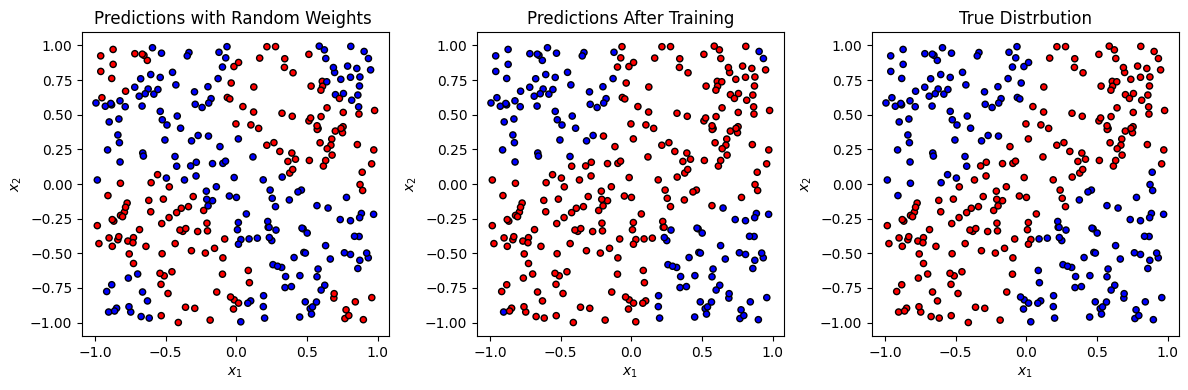

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_data(X_test, y_pred_initial, fig, axes[0])
plot_data(X_test, y_pred, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title(f"Predictions with Random Weights ")
axes[1].set_title(f"Predictions After Training")
axes[2].set_title("True Distrbution")
plt.tight_layout()
plt.show()